# Image segmentation with a U-Net architecture

#### Description: Image segmentation model trained from scratch on the Oxford Pets dataset.
#### Source: https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [1]:
# Download data
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  27.9M      0  0:00:27  0:00:27 --:--:-- 29.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  9854k      0  0:00:01  0:00:01 --:--:-- 9849k


In [3]:
!ls 

annotations  annotations.tar.gz  images  images.tar.gz	sample_data


In [9]:
# imports 
import os
from tqdm import tqdm
import random
from IPython.display import Image, display

import numpy as np

import PIL
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

print(f"Numpy : {np.__version__}")
print(f"Tensorflow : {tf.__version__}")

Numpy : 1.19.5
Tensorflow : 2.7.0


In [10]:
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

#### Prepare paths of input images and target segmentation masks

In [4]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

# get all input images
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

# get all target annotation imgaes
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))
print("Number of annotaions:", len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

# test that the filenames match and each image has a corresponding annotation image
for input_path, target_path in tqdm(zip(input_img_paths, target_img_paths)): 
    input_fname = os.path.split(input_path)[-1]
    target_fname = os.path.split(target_path)[-1]

    input_fname_without_ext = os.path.splitext(input_fname)[0]
    target_fname_without_ext = os.path.splitext(target_fname)[0]
    assert input_fname_without_ext == target_fname_without_ext

Number of samples: 7390
Number of annotaions: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


7390it [00:00, 129777.95it/s]


#### Visualize data 

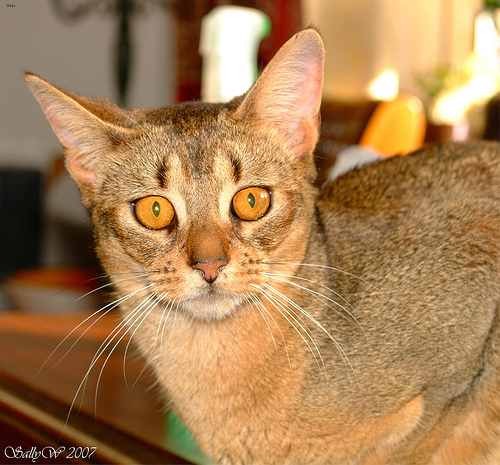

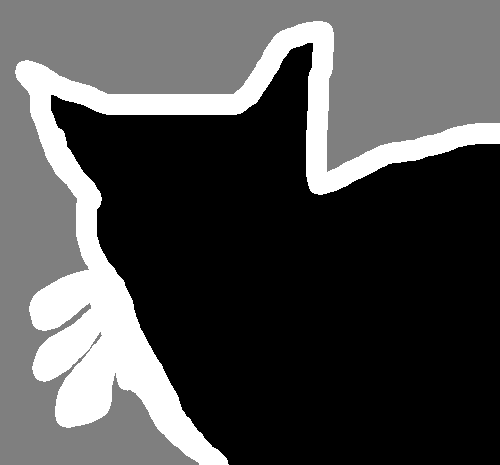

In [5]:
idx = 4
# Display input image #idx
display(Image(filename=input_img_paths[idx]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[idx]))
display(img)

#### Examine the shape of images

In [16]:
shapes = []
# test that the filenames match and each image has a corresponding annotation image
for input_path in tqdm(input_img_paths): 
    img = load_img(input_path)
    h,w = img.size
    shapes.append([h,w])
shapes = np.asarray(shapes)

100%|██████████| 7390/7390 [00:01<00:00, 6428.65it/s]


(array([2.954e+03, 4.385e+03, 2.400e+01, 1.200e+01, 7.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([ 103. ,  353.3,  603.6,  853.9, 1104.2, 1354.5, 1604.8, 1855.1,
        2105.4, 2355.7, 2606. ]),
 <a list of 10 Patch objects>)

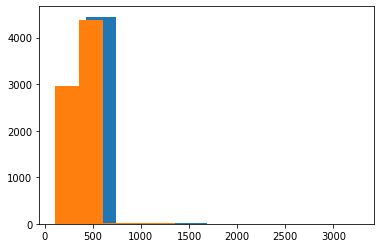

In [18]:
plt.hist(shapes[:,0]) 
plt.hist(shapes[:,1]) 

#### Prepare Sequence class to load & vectorize batches of data

In [19]:
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


#### Prepare U-Net Xception-style model

In [21]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [22]:
from tensorflow.keras.utils import plot_model

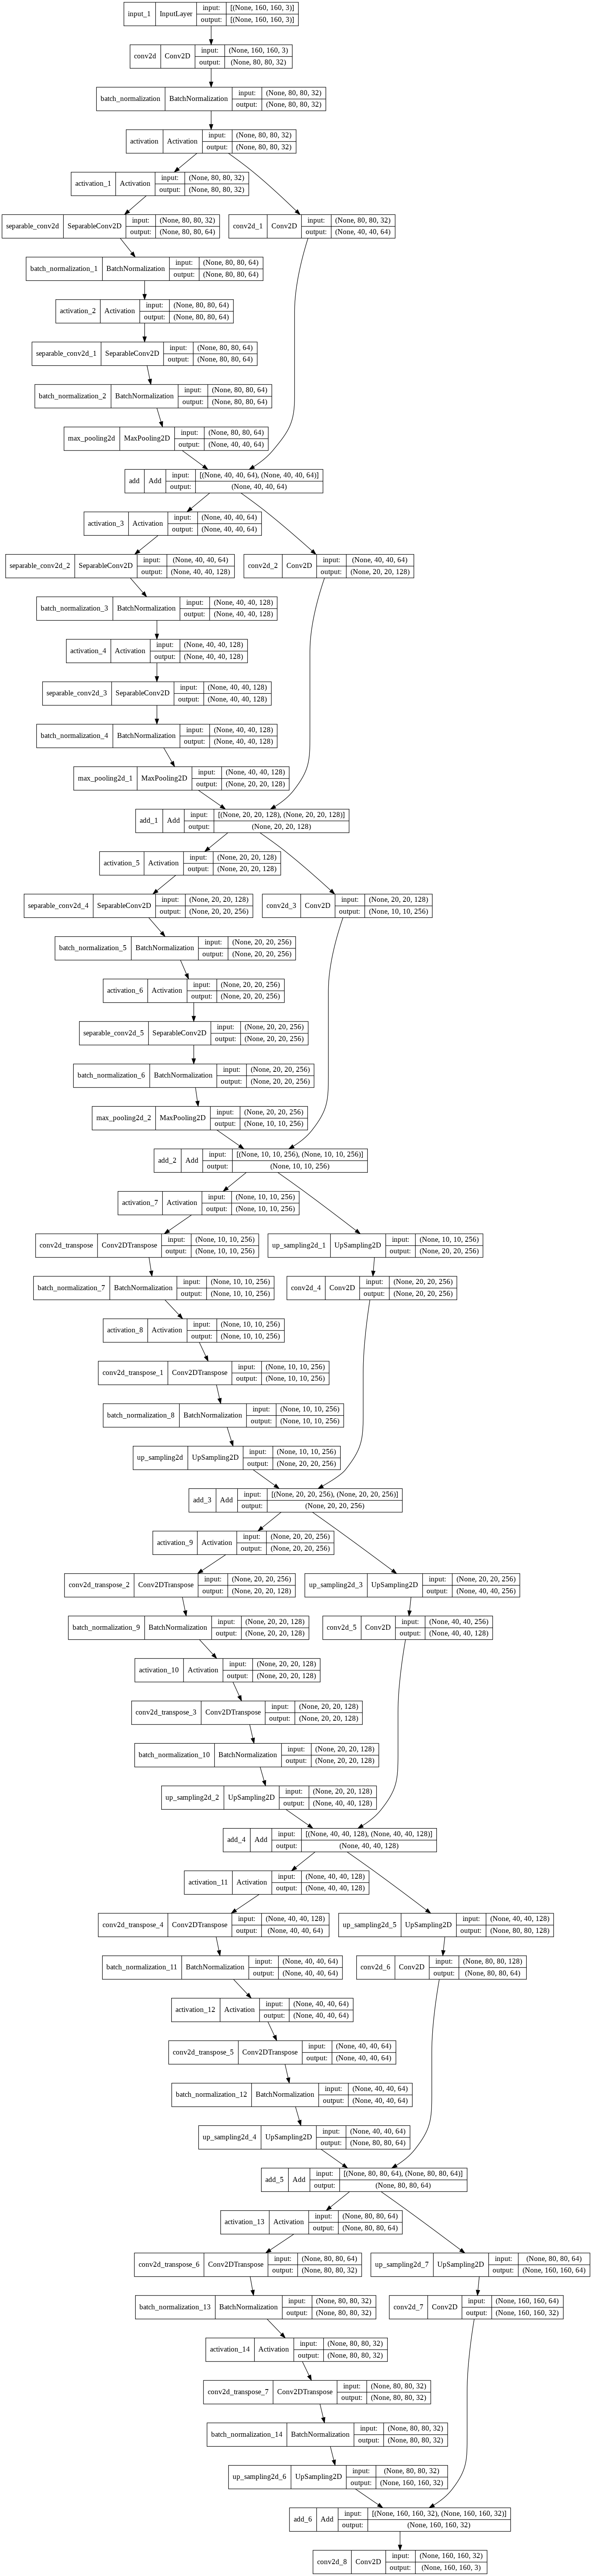

In [24]:
plot_model(model, show_shapes=True)

#### Set aside a validation split

In [25]:
# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
print(batch_size, img_size)

32 (160, 160)


### Train the model

In [26]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
hist = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
199/199 [==============================] - ETA: 0s - loss: 0.9717

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



199/199 [==============================] - 132s 558ms/step - loss: 0.9717 - val_loss: 1.8040
Epoch 2/50
199/199 [==============================] - 110s 552ms/step - loss: 0.5080 - val_loss: 2.1699
Epoch 3/50
199/199 [==============================] - 110s 552ms/step - loss: 0.4294 - val_loss: 0.4923
Epoch 4/50
199/199 [==============================] - 110s 552ms/step - loss: 0.3849 - val_loss: 0.4118
Epoch 5/50
199/199 [==============================] - 109s 548ms/step - loss: 0.3507 - val_loss: 0.4120
Epoch 6/50
199/199 [==============================] - 110s 551ms/step - loss: 0.3222 - val_loss: 0.3766
Epoch 7/50
199/199 [==============================] - 110s 550ms/step - loss: 0.2954 - val_loss: 0.3679
Epoch 8/50
199/199 [==============================] - 109s 549ms/step - loss: 0.2733 - val_loss: 0.3892
Epoch 9/50
199/199 [==============================] - 110s 550ms/step - loss: 0.2542 - val_loss: 0.3807
Epoch 10/50
199/199 [==============================] - 109s 548ms/step - lo

#### Show predictions

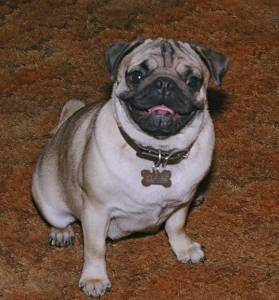

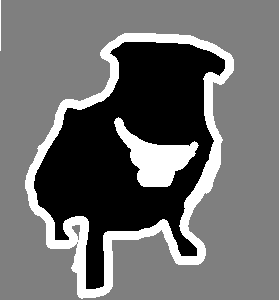

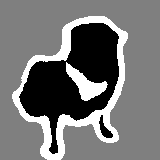

In [27]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.